In [15]:
import os
import random
import sys
import time
import community
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt 

from src import settings
from src.utils import fileio, graph_utils
c = ['Mean degree weight=count', 'Mean degree weight=duration(seconds)',
     'Degree heterogeneity (count)', 'Degree heterogeneity (total duration (seconds))',
 'Degree aassortativity (count)', 'Degree aassortativity (total duration (seconds))',
 'Average clustering coefficient weight=count', 'Average clustering coefficient weight=duration(seconds)',
 'Average betweenness centrality weight=count', 'Average betweenness centrality weight=duration(seconds)',
 'Average closseness centrality weight=count', 'Average closseness centrality weight=duration(seconds)']

TREATMENTS = ['CS_10D', 'CsCh', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']

all_res = pd.DataFrame()
for TREATMENT in TREATMENTS:
    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_2_create_total_graph", TREATMENT)
    graphs = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/results/global_measures/{TREATMENT}.csv"
    df = pd.read_csv(graphs, index_col=0)
    df = df[c]
    shuffled_path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/results/shuffled_nets_global_measures/{TREATMENT}"
    all_shuff = fileio.load_multiple_folders(shuffled_path)

    res = []
    for name, path in all_shuff.items():
        shuff_measures = fileio.load_files_from_folder(path)

        df_shuff = pd.read_csv(shuff_measures[f"{name}.csv"], index_col=0)
        df_shuff = df_shuff[c]
        df_shuff = df_shuff.agg(['mean', 'std'])
        
        epsilon = 1e-5
        df_shuff.loc["std"] = df_shuff.loc["std"].apply(lambda x: 0 if x < epsilon else x)
        
        r = (df.loc[name] - df_shuff.loc["mean"]) / df_shuff.loc["std"]
        r['Group'] = name
        r['Treatment'] = TREATMENT
        res.append(r)

    df_res = pd.DataFrame(res)
    df_res = df_res.set_index(['Treatment', 'Group'])

    all_res = pd.concat([all_res, df_res])

vals = all_res.groupby(level=['Treatment']).agg(['mean', 'sem'])

normalized_columns = {
    'vel': 'Velocity',
    'ang_vel': 'Angular velocity',
    'min_wing_ang': 'Minimum wing angle',
    'max_wing_ang': 'Maximum wing angle',
    'mean_wing_length': 'Mean Wing length',
    'dist_to_wall': 'Distance to wall',
    'dist_from_center': 'Distance from center',
    'dist_to_closest': 'Distance to closest Fly',
    'mean_dist_to_all': 'Mean distance to all flies',
    'Mean degree weight=count': 'Strength (Count)',
    'Mean degree weight=duration(seconds)': 'Strength (Duration)',
    'Degree heterogeneity (count)': 'Degree Heterogeneity (Count)',
    'Degree heterogeneity (total duration (seconds))': 'Degree Heterogeneity (Duration)',
    'Degree aassortativity (count)': 'Degree Assortativity (Count)',
    'Degree aassortativity (total duration (seconds))': 'Degree Assortativity (Duration)',
    'Average clustering coefficient weight=count': 'Clustering Coefficient (Count)',
    'Average clustering coefficient weight=duration(seconds)': 'Clustering Coefficient (Duration)',
    'Average betweenness centrality weight=count': 'Betweenness Centrality (Count)',
    'Average betweenness centrality weight=duration(seconds)': 'Betweenness Centrality (Duration)',
    'Average closseness centrality weight=count': 'Closeness Centrality (Count)',
    'Average closseness centrality weight=duration(seconds)': 'Closeness Centrality (Duration)'
}

vals.rename(columns=normalized_columns, inplace=True)

desired_order = [
    'Strength (Count)',
    'Strength (Duration)',
    'Degree Heterogeneity (Count)',
    'Degree Heterogeneity (Duration)',
    'Degree Assortativity (Count)',
    'Degree Assortativity (Duration)',
    'Clustering Coefficient (Count)',
    'Clustering Coefficient (Duration)',
    'Betweenness Centrality (Count)',
    'Betweenness Centrality (Duration)',
    'Closeness Centrality (Count)',
    'Closeness Centrality (Duration)'
]
def plot_means_with_error_bars(global_measures_t, selected_treatments, colors, error_type, xlim, title):
    sample = global_measures_t[selected_treatments]
    sample.index = sample.index.set_names(['measure', 'mean_std'])
    measures = sample.index.get_level_values('measure').unique().to_list()
    measurements, sds = [[] for _ in selected_treatments], [[] for _ in selected_treatments]
    measures = desired_order
    for i, measure in enumerate(measures):
        data = sample.xs(measure, level='measure')
        for j, treatment in enumerate(selected_treatments):
            measurements[j].append(data[treatment]['mean'])
            sds[j].append(data[treatment][error_type])

    _, ax = plt.subplots(figsize=(4, 8))
    for i, treatment in enumerate(selected_treatments):
        ax.errorbar(measurements[i], measures, xerr=sds[i], fmt='o', color=colors[treatment],
                    ecolor=colors[treatment], elinewidth=2, capsize=0)
        ax.scatter(measurements[i], measures, color=colors[treatment], label=treatment, s=100)

    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    ax.set_xlabel('Z score')
    ax.legend(loc='center left', bbox_to_anchor=(0.36, 1.11))
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.title(title, pad=110)
    plt.show()

import seaborn as sns
colorblind_palette = sns.color_palette("colorblind", n_colors=6)

colors = {
    'CS_10D': colorblind_palette[0],
    'Cs_5DIZ': colorblind_palette[1],
    'LDA_OCT_5DIZ': colorblind_palette[2],
    'LDA_5DIZ': colorblind_palette[3],
    'OCT_5DIZ': colorblind_palette[4],
    'CsCh': colorblind_palette[5],
}

selected_treatments = ['CS_10D', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
plot_means_with_error_bars(vals.T, selected_treatments, colors, error_type='sem', xlim=[-5, 10], title="No social structure networks used for null")


In [11]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from src import settings
from src.utils import fileio, graph_utils

c = ['Mean degree weight=count', 'Mean degree weight=duration(seconds)',
     'Degree heterogeneity (count)', 'Degree heterogeneity (total duration (seconds))',
 'Degree aassortativity (count)', 'Degree aassortativity (total duration (seconds))',
 'Average clustering coefficient weight=count', 'Average clustering coefficient weight=duration(seconds)',
 'Average betweenness centrality weight=count', 'Average betweenness centrality weight=duration(seconds)',
 'Average closseness centrality weight=count', 'Average closseness centrality weight=duration(seconds)']

TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']

all_res = pd.DataFrame()
for TREATMENT in TREATMENTS:
    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_2_create_total_graph", TREATMENT)
    graphs = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/results/global_measures/{TREATMENT}.csv"
    df = pd.read_csv(graphs, index_col=0)
    df = df[c]
    shuffled_path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/results/shuffled_nets_global_measures/{TREATMENT}"
    all_shuff = fileio.load_multiple_folders(shuffled_path)

    res = []
    for name, path in all_shuff.items():
        shuff_measures = fileio.load_files_from_folder(path)
        df_shuff = pd.read_csv(shuff_measures[f"{name}.csv"], index_col=0)
        df_shuff = df_shuff[c]
        
        p_values = {}
        for measure in c:
            x_obs = df[measure].loc[name]
            random_measures = df_shuff[measure].to_numpy()
            extreme_values = np.sum(random_measures >= x_obs)
            p_value = extreme_values / len(random_measures)
            p_values[f"{measure}"] = p_value
        
        r = pd.Series(p_values)
        r['Group'] = name
        r['Treatment'] = TREATMENT
        res.append(r)

    df_res = pd.DataFrame(res)
    df_res = df_res.set_index(['Treatment', 'Group'])
    all_res = pd.concat([all_res, df_res])

significant_counts = all_res.apply(lambda x: x < 0.05).groupby("Treatment").sum()

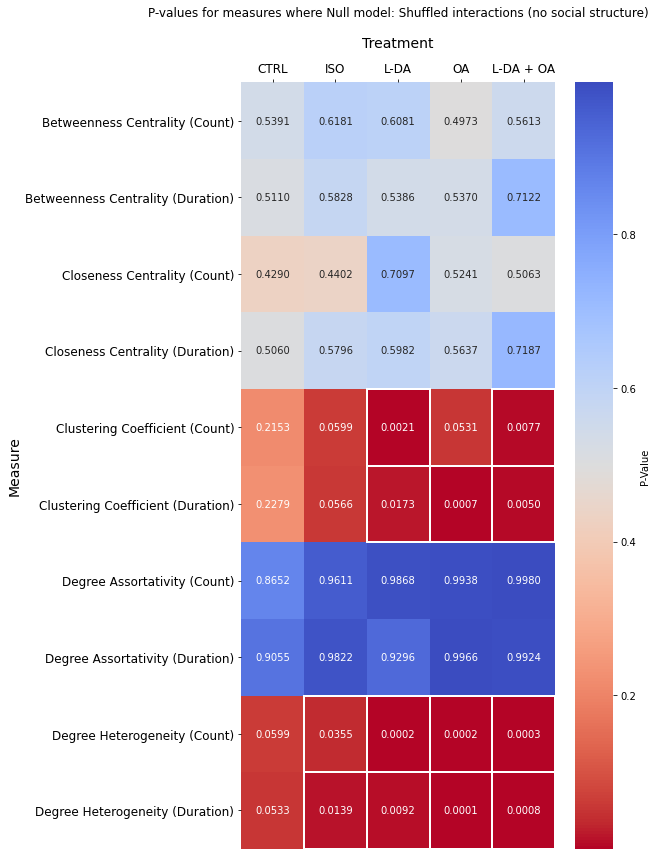

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

normalized_columns = {
    # 'Mean degree weight=count': 'Strength (Count)',
    # 'Mean degree weight=duration(seconds)': 'Strength (Duration)',
    'Degree heterogeneity (count)': 'Degree Heterogeneity (Count)',
    'Degree heterogeneity (total duration (seconds))': 'Degree Heterogeneity (Duration)',
    'Degree aassortativity (count)': 'Degree Assortativity (Count)',
    'Degree aassortativity (total duration (seconds))': 'Degree Assortativity (Duration)',
    'Average clustering coefficient weight=count': 'Clustering Coefficient (Count)',
    'Average clustering coefficient weight=duration(seconds)': 'Clustering Coefficient (Duration)',
    'Average betweenness centrality weight=count': 'Betweenness Centrality (Count)',
    'Average betweenness centrality weight=duration(seconds)': 'Betweenness Centrality (Duration)',
    'Average closseness centrality weight=count': 'Closeness Centrality (Count)',
    'Average closseness centrality weight=duration(seconds)': 'Closeness Centrality (Duration)'
}

c = ['Degree heterogeneity (count)', 'Degree heterogeneity (total duration (seconds))',
 'Degree aassortativity (count)', 'Degree aassortativity (total duration (seconds))',
 'Average clustering coefficient weight=count', 'Average clustering coefficient weight=duration(seconds)',
 'Average betweenness centrality weight=count', 'Average betweenness centrality weight=duration(seconds)',
 'Average closseness centrality weight=count', 'Average closseness centrality weight=duration(seconds)']

all_res = all_res[c]

all_res.rename(columns=normalized_columns, inplace=True)

heatmap_data = all_res.reset_index()
heatmap_data = heatmap_data.set_index(['Treatment', 'Group']).stack().reset_index()
heatmap_data.columns = ['Treatment', 'Group', 'Measure', 'P-Value']
heatmap_data = heatmap_data.pivot_table(index='Measure', columns='Treatment', values='P-Value')
# heatmap_data = heatmap_data.drop(columns=['CsCh'])
heatmap_data.columns = ['CS_10D', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']

renamed_treatments = {
    'CS_10D': 'CTRL',
    'Cs_5DIZ' : 'ISO',
    'LDA_5DIZ' : 'L-DA',
    'OCT_5DIZ' : 'OA',
    'LDA_OCT_5DIZ' : 'L-DA + OA'
    } 

heatmap_data.rename(columns=renamed_treatments, inplace=True)

plt.figure(figsize=(9, 12))
ax = sns.heatmap(heatmap_data, cmap="coolwarm_r", annot=True, fmt=".4f", cbar_kws={'label': 'P-Value'})

for i in range(heatmap_data.shape[0]):  # Iterate over rows (measures)
    for j in range(heatmap_data.shape[1]):  # Iterate over columns (treatments)
        p_value = heatmap_data.iloc[i, j]
        if p_value <= 0.05:
            ax.add_patch(patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='white', facecolor='none'))

plt.title('P-values for measures where Null model: Shuffled interactions (no social structure)', pad=20)
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis labels to the top
plt.gca().xaxis.set_label_position('top')  # Move x-axis title to the top

plt.xlabel('Treatment', fontsize = 14, labelpad=15)
plt.ylabel('Measure', fontsize = 14)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Column headers (treatments)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Row headers (measures)

OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "CUG_test")
os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.tight_layout()

save_path_png = os.path.join(OUTPUT_DIR, f"soc_structure.jpg")
save_path_svg = os.path.join(OUTPUT_DIR, f"soc_structure.svg")
plt.savefig(save_path_png, dpi=500)
plt.savefig(save_path_svg, dpi=500)

plt.show()

In [13]:

c = ['Mean degree weight=count', 'Mean degree weight=duration(seconds)',
 'Degree heterogeneity (count)', 'Degree heterogeneity (total duration (seconds))',
 'Degree aassortativity (count)', 'Degree aassortativity (total duration (seconds))',
 'Average clustering coefficient weight=count', 'Average clustering coefficient weight=duration(seconds)',
 'Average betweenness centrality weight=count', 'Average betweenness centrality weight=duration(seconds)',
 'Average closseness centrality weight=count', 'Average closseness centrality weight=duration(seconds)']


TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'CsCh', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
path = "/srv/milky/drosophila-datasets/drosophila-isolation/data/results/global_measures"
measures = fileio.load_files_from_folder(path, '.csv')

global_measures = pd.DataFrame()
global_measures_p_values = pd.DataFrame()
for TREATMENT in TREATMENTS:
    df = pd.read_csv(measures[f"{TREATMENT}.csv"], index_col=0)
    df = df[c]
    df['Treatment'] = TREATMENT
    df_pseudo = pd.read_csv(measures[f"pseudo_{TREATMENT}.csv"], index_col=0)
    df_pseudo = df_pseudo[c]

    res = []
    for name in df.index:
        p_values = {}
        for measure in c:
            x_obs = df.loc[name, measure]
            random_measures = df_pseudo[measure].to_numpy()
            extreme_values = np.sum(random_measures >= x_obs)
            p_value = extreme_values / len(random_measures)
            p_values[f"{measure}"] = p_value
        
        r = pd.Series(p_values)
        r['Group'] = name
        r['Treatment'] = TREATMENT
        res.append(r)

    df_res = pd.DataFrame(res)
    df_res = df_res.set_index(['Treatment', 'Group'])
    global_measures_p_values = pd.concat([global_measures_p_values, df_res])

normalized_columns = {
    'Mean degree weight=count': 'Strength (Count)',
    'Mean degree weight=duration(seconds)': 'Strength (Duration)',
    'Degree heterogeneity (count)': 'Degree Heterogeneity (Count)',
    'Degree heterogeneity (total duration (seconds))': 'Degree Heterogeneity (Duration)',
    'Degree aassortativity (count)': 'Degree Assortativity (Count)',
    'Degree aassortativity (total duration (seconds))': 'Degree Assortativity (Duration)',
    'Average clustering coefficient weight=count': 'Clustering Coefficient (Count)',
    'Average clustering coefficient weight=duration(seconds)': 'Clustering Coefficient (Duration)',
    'Average betweenness centrality weight=count': 'Betweenness Centrality (Count)',
    'Average betweenness centrality weight=duration(seconds)': 'Betweenness Centrality (Duration)',
    'Average closseness centrality weight=count': 'Closeness Centrality (Count)',
    'Average closseness centrality weight=duration(seconds)': 'Closeness Centrality (Duration)'
}

global_measures_p_values.rename(columns=normalized_columns, inplace=True)
significant_counts = global_measures_p_values.apply(lambda x: x < 0.05).groupby("Treatment").sum()


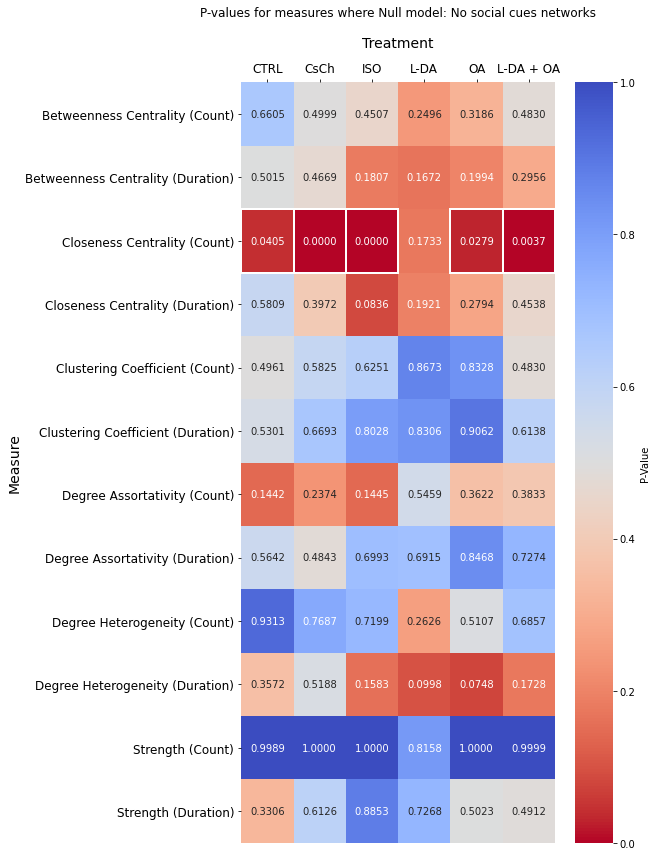

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
heatmap_data = global_measures_p_values.reset_index()
heatmap_data = heatmap_data.set_index(['Treatment', 'Group']).stack().reset_index()
heatmap_data.columns = ['Treatment', 'Group', 'Measure', 'P-Value']
heatmap_data = heatmap_data.pivot_table(index='Measure', columns='Treatment', values='P-Value')
heatmap_data.columns = ['CS_10D','CsCh', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
renamed_treatments = {
    'CS_10D': 'CTRL',
    'Cs_5DIZ' : 'ISO',
    'LDA_5DIZ' : 'L-DA',
    'OCT_5DIZ' : 'OA',
    'LDA_OCT_5DIZ' : 'L-DA + OA',
    'CsCh': 'CsCh'
    } 

heatmap_data.rename(columns=renamed_treatments, inplace=True)

plt.figure(figsize=(9, 12))
ax = sns.heatmap(heatmap_data, cmap="coolwarm_r", annot=True, fmt=".4f", cbar_kws={'label': 'P-Value'})

for i in range(heatmap_data.shape[0]):  # Iterate over rows (measures)
    for j in range(heatmap_data.shape[1]):  # Iterate over columns (treatments)
        p_value = heatmap_data.iloc[i, j]
        if p_value <= 0.05:
            ax.add_patch(patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='white', facecolor='none'))

plt.title('P-values for measures where Null model: No social cues networks', pad=20)
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis labels to the top
plt.gca().xaxis.set_label_position('top')  # Move x-axis title to the top

plt.xlabel('Treatment', fontsize = 14, labelpad=15)
plt.ylabel('Measure', fontsize = 14)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Column headers (treatments)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Row headers (measures)

OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "CUG_test")
os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.tight_layout()

save_path_png = os.path.join(OUTPUT_DIR, f"soc_cue.jpg")
save_path_svg = os.path.join(OUTPUT_DIR, f"soc_cue.svg")
plt.savefig(save_path_png, dpi=500)
plt.savefig(save_path_svg, dpi=500)

plt.show()

In [23]:
weights = {
    '1': 33,
    '2': 33,
    '3': 33,
    '4': 1,
    '5': 1,
    '6': 1,
    '7': 1,
    '8': 1,
    '9': 1,
    '10': 1,
    '11': 1,
    '12': 1
}

total_strength = sum(weights.values())
average_strength = total_strength / len(weights)

average_strength

9.0